# Processing perturbation coefficients using `sandy`

In [1]:
import sandy
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We define a multigroup perturbation as a series of tabulated pairs `(energy value, perturbation coefficient)`, 
where the energy values are the right bounds of the energy bins that define the perturbation coefficient as a 
step function.

In [3]:
grid   = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e5, 1e6, 1e7, 2e7] # right bounds of each energy interval
values = [   1,  1.4,  1.3,  1.2,  1.1, 0.6, 1.8, 1.9, 1.9, 1.6]
series = pd.Series(values, index=grid)
pert = sandy.Pert(series)
pert

ENERGY
(0.0, 1e-05]               1.00000e+00
(1e-05, 0.0001]            1.40000e+00
(0.0001, 0.001]            1.30000e+00
(0.001, 0.01]              1.20000e+00
(0.01, 0.1]                1.10000e+00
(0.1, 1.0]                 6.00000e-01
(1.0, 100000.0]            1.80000e+00
(100000.0, 1000000.0]      1.90000e+00
(1000000.0, 10000000.0]    1.90000e+00
(10000000.0, 20000000.0]   1.60000e+00
dtype: float64

The `pert` variable is a `sandy.Pert` instance and it contains perturbation coefficients 
into a `pandas.Series` with a `pandas.IntervalIndex` that defines the energy bins.

> Perturbation values are given in fractions!
> As such, a perturbation value is obtained multiplying the reference value by the perturbation coefficient.
> Then, a perturbation coefficient equal to one does not apply any perturbation.

For plotting and analysis purposes we are often interested in tabulated values that are not indexed by energy bins, 
but by scalar energy values.
By calling attribute `.right` the instance returns a `pandas.Series` with perturbation coefficients as `.values` and the 
right bounds of the energy bins as `.index`.

Try also `pert.left` and `pert.mid`.

In [4]:
pert.right

1.00000e-05   1.00000e+00
1.00000e-04   1.40000e+00
1.00000e-03   1.30000e+00
1.00000e-02   1.20000e+00
1.00000e-01   1.10000e+00
1.00000e+00   6.00000e-01
1.00000e+05   1.80000e+00
1.00000e+06   1.90000e+00
1.00000e+07   1.90000e+00
2.00000e+07   1.60000e+00
dtype: float64

We can resort to the outputs produced by attributes `.right` and `.left` to plot the perturbation coefficients.
*Notice that for a correct rendering of the output of `.left` 'steps-post' should be assigned to 
the drawstyle argument*.

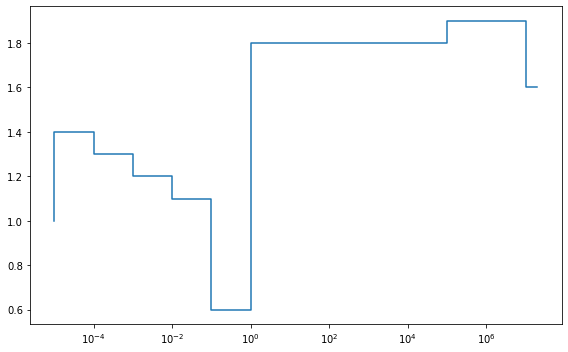

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
pert.right.plot(logx=True, drawstyle="steps", ax=ax)
plt.tight_layout();

Perturbation objects can also be printed to a `.csv` or text file with columns divided by a specific separator.

In [6]:
pert.right.to_csv("pert.csv", sep=",", header=False)
with open("pert.csv") as f:
    text = f.read()
print(text)

1e-05,1.0
0.0001,1.4
0.001,1.3
0.01,1.2
0.1,1.1
1.0,0.6
100000.0,1.8
1000000.0,1.9
10000000.0,1.9
20000000.0,1.6



Perturbations could even be imported into `sandy` directly from a text file.  

In [7]:
sandy.Pert.from_file("pert.csv", sep=",")

ENERGY
(0.0, 1e-05]               1.00000e+00
(1e-05, 0.0001]            1.40000e+00
(0.0001, 0.001]            1.30000e+00
(0.001, 0.01]              1.20000e+00
(0.01, 0.1]                1.10000e+00
(0.1, 1.0]                 6.00000e-01
(1.0, 100000.0]            1.80000e+00
(100000.0, 1000000.0]      1.90000e+00
(1000000.0, 10000000.0]    1.90000e+00
(10000000.0, 20000000.0]   1.60000e+00
dtype: float64

Eventually, a common request is to reshape the perturbation coefficients according the energy structure 
of, say, a cross section to directly implement a vector-vector multiplication.
This can be done using method `.reshape` to which the new energy grid is provided.

In [8]:
new_grid = [1e6, 2e6, 5e6, 1e7, 2e7]
pert2 = pert.reshape(new_grid)
pert2

ENERGY
(0.0, 1e-05]               1.00000e+00
(1e-05, 0.0001]            1.40000e+00
(0.0001, 0.001]            1.30000e+00
(0.001, 0.01]              1.20000e+00
(0.01, 0.1]                1.10000e+00
(0.1, 1.0]                 6.00000e-01
(1.0, 100000.0]            1.80000e+00
(100000.0, 1000000.0]      1.90000e+00
(1000000.0, 2000000.0]     1.90000e+00
(2000000.0, 5000000.0]     1.90000e+00
(5000000.0, 10000000.0]    1.90000e+00
(10000000.0, 20000000.0]   1.60000e+00
dtype: float64

The reshaped `pert2` objects contains the perturbation coefficients defined over a union between 
the original and the new energy grids.

Of course the two plots overlap as the information does not change.

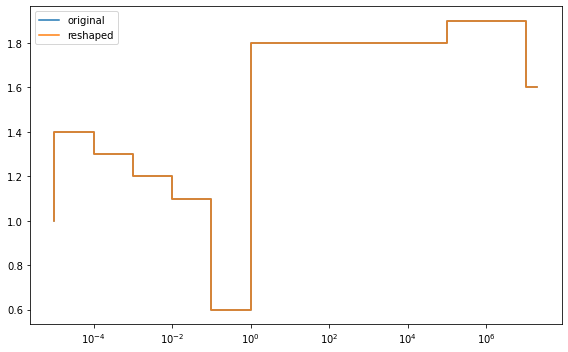

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
pert.right.plot(logx=True, drawstyle="steps", label="original", ax=ax)
pert2.right.plot(logx=True, drawstyle="steps", label="reshaped", ax=ax)
ax.legend(loc=2)
plt.tight_layout();

## Truncate perturbations

Since perturbation coefficients are essentially fraction, if they are lower than 0 or higher than 2 they will introduce perturbations larger than 100%.

Below we construct a `Pert` object with normally distributed perturbation coefficients.
Since the distribution is centered in 1 and the standard deviation is 0.5, we end up having perturbation values that exceed the limits defined above.

In [10]:
grid = sandy.uniform_loggrid(1e-5, 2e7, 1000)
np.random.seed(1)
values = np.random.normal(1, 0.5, grid.size)
pp = sandy.Pert(values, index=grid, name="original")

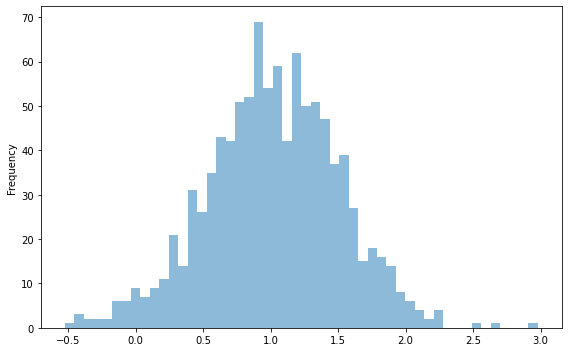

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
bins = 50
pp.right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
plt.tight_layout();

`Pert` method `.truncate` replaces any perturbation coefficient below a given lower value with the boundary value itself. The same happens for the upper value.

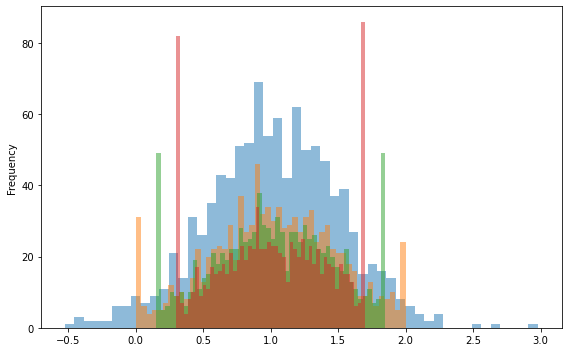

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
bins = 50
pp.right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
pp.truncate().right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
pp.truncate(low=0.15, high=1.85).right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
pp.truncate(low=0.3, high=1.7).right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
plt.tight_layout();

Alternatively, method recenter replaces the outliers with the central value `1.0` or with another value of choice.

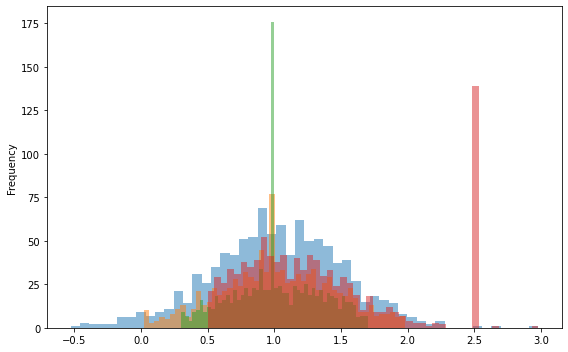

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
bins = 50
pp.right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
pp.recenter().right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
pp.recenter(low=0.3, high=1.7).right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
pp.recenter(low=0.5, high=10, value=2.5).right.plot(kind="hist", ax=ax, bins=bins, alpha=0.5)
plt.tight_layout();